# Introduction to Decision Trees

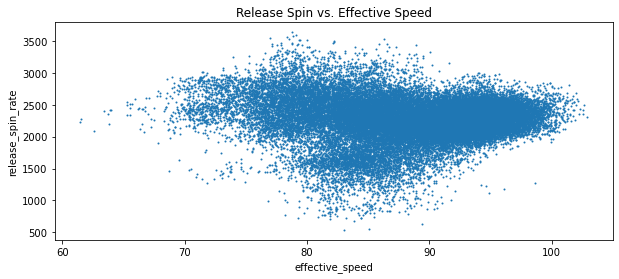

In [1]:
# Let's go back to the pitching data we used previously for SVMs!
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
from mlxtend.plotting import plot_decision_regions

filename="baseball_svm_data.zip"
df=pd.read_csv(zipfile.ZipFile(filename).open("reg_Sep2019.csv"))

df.plot.scatter("effective_speed", "release_spin_rate", 
                s=1, figsize=(10, 4), title="Release Spin vs. Effective Speed");


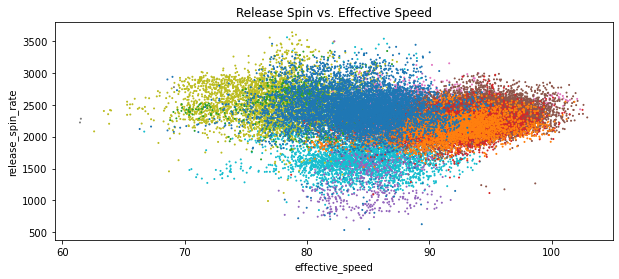

In [2]:
# Now remember, this actually has many different kinds of pitches,
# so let's take a look at some of the overlaps
import matplotlib.colors as mcolors
color_list=list(mcolors.TABLEAU_COLORS.keys())
df=df.groupby("pitch_type").apply(lambda x: x.assign(color=color_list.pop())).reset_index(drop=True)
df.plot.scatter("effective_speed", "release_spin_rate", 
                s=1, figsize=(10, 4), title="Release Spin vs. Effective Speed",
                color=df["color"], legend=True);

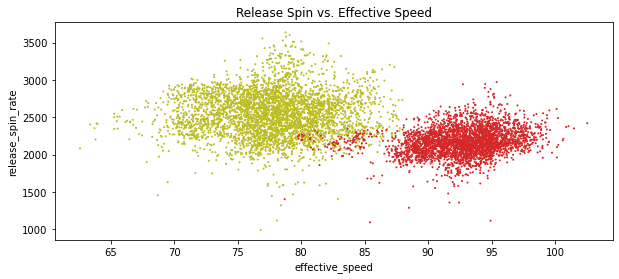

In [3]:
# Ok, there are some categories which seem pretty distinct, and some not so
# much. Let's go back to our initial two kinds of pitches, fastballs and change ups
df_small=df[df["pitch_type"].isin(["FT","CU"])]
df_small=df_small[["effective_speed", "release_spin_rate", "color", "pitch_type"]]
df_small=df_small.dropna()

# Now let's plot this
df_small.plot.scatter("effective_speed", "release_spin_rate", s=1, c="color", figsize=(10, 4), 
                legend=True, title="Release Spin vs. Effective Speed");

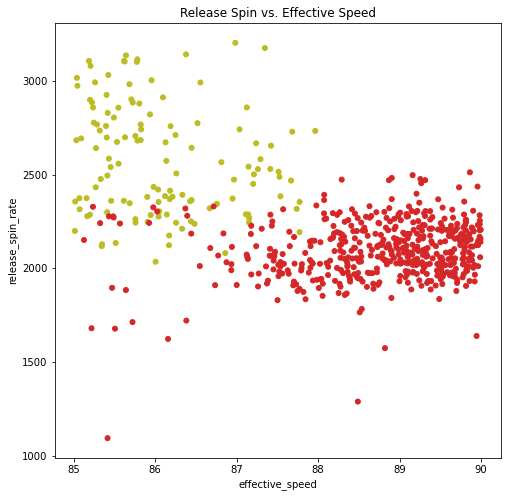

In [4]:
# Now, for the sake of teaching, let's zoom in on an area of data which has
# some interesting overlap. I played around with the data and I think we
# we limit the speed between 85 and 90 miles per hour we should have something.
# and we can just look at a thousand entries
df_small=df_small.query("effective_speed <90 and effective_speed > 85")
df_small=df_small[0:999]

# Now let's plot this
df_small.plot.scatter("effective_speed", "release_spin_rate", s=25, c="color", figsize=(8, 8), 
                legend=True, title="Release Spin vs. Effective Speed");

Now, look at this area for a moment. We're only considering two features, the effective speed of the pitch and the release spin rate. Our fastballs are in red, and our change ups are in yellow. A descision tree has to decide on one binary split to make - so a rule with either the release spin rate **or** the effective speed. If you were going to segment this space, how would you do it?

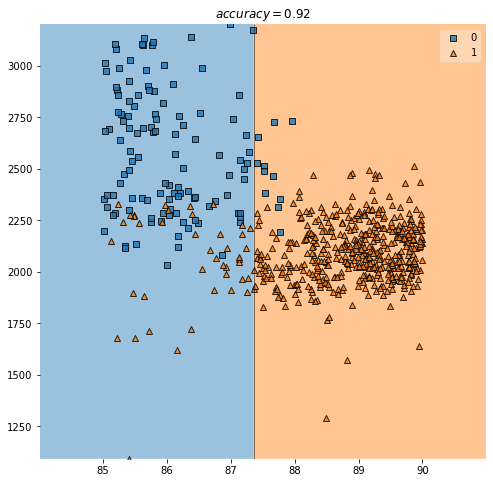

In [5]:
# Well, the way the CART algorithm works is that it looks to separate the dataset into
# two smaller datasets, where each one is as pure -- which means homogenous with respect
# to the classes it has in it -- relative to its size. So the tree algorithm considers
# our two features, and attempts to segment them based on a measure of impurity. This is
# actually very hard for large datasets, so instead the method used aims to estimate
# impurity (and there are several different methods).

# Now, we only consider one feature, because this is a recursive process. For each of the
# smaller datasets we'll just run the algorithm again, breaking them into two more
# datasets. We stop when either all of the data we have left in the node is of a single
# class (e.g. only fastballs), or until some threshold has been hit.

# Let's build the model and see what CART would use to separate this space.
X=df_small[["effective_speed","release_spin_rate"]]
# Remember that for y hat we want to factorize to get a 1 or a 0 for our classes
y=df_small["pitch_type"]
y=df_small["pitch_type"].factorize()[0]

# Here I'm going to constrain the tree to just a single level of depth, and I'll set
# my random state just like I did before
from sklearn.tree import DecisionTreeClassifier
clf=DecisionTreeClassifier(max_depth=1, random_state=1337)
clf=clf.fit(X,y)

# With the model fitted to the data I'll use Sebastian's great descision region
# code again to get a look
plt.figure(figsize=(8,8))
plot_decision_regions(X.to_numpy(), y, clf, ax=plt.gca())
plt.gca().set_title(f"$accuracy={clf.score(X,y):.2f}$");

Ok, so we see that the tree decided to split using the effective speed at about 87 and a half miles per hour, and we can see the accuracy is only 92%. How close was this to where you would have split the data? Regardless, the orange triangles on the left and the blue squares towards the top suggest we could do better if we recursed a bit more deeply. Keep in mind that because we are going to look at each side of the tree individually, we actually have two more splits we can do, one for the left hand side (under 87.5 mph) and one for the right hand side. These splits are independent!

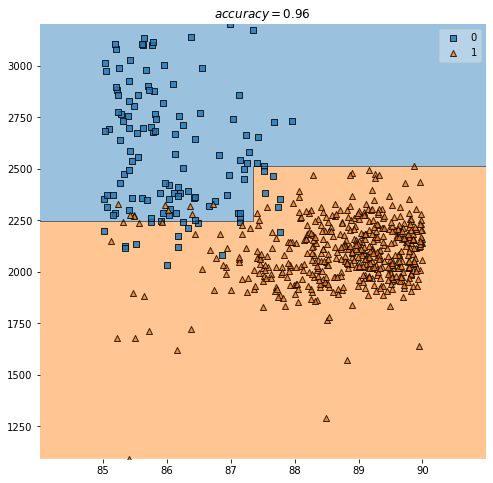

In [6]:
# We can just increase our max depth parameter and look a bit deeper.
clf=DecisionTreeClassifier(max_depth=2, random_state=1337)
clf=clf.fit(X,y)

plt.figure(figsize=(8,8))
plot_decision_regions(X.to_numpy(), y, clf, ax=plt.gca())
plt.gca().set_title(f"$accuracy={clf.score(X,y):.2f}$");

Great, so accuracy shot up a bit to 96%. We see that the tree split on the second feature, our release spin rate, for both the right hand and left hand subtrees. But, this happened at different values, around 2,250 for the left hand side and 2,500 for the right hand side. We now have four leaf nodes in the tree. But what are the rules that were actually created?

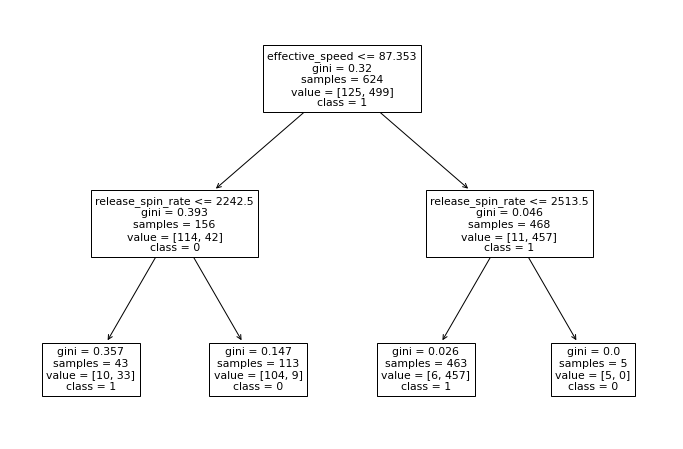

In [7]:
# sklearn has built in functions to display the actual decision tree itself
from sklearn.tree import plot_tree

fig= plt.figure(figsize=(12,8))
plot_tree(clf, feature_names=X.columns, class_names=np.unique(y.astype(str)));    

Ok, so here is our decision tree. Let's walk through it. In each node we see the rule, which is a binary comparison - a greater than or less than - with respect to a single feature. At the root node we see that the split happens at 87.353 miles per hour of effective speed. Right under that is the gini value. This is a measure of impurity, and we can control the algorithm CART uses and the default is the Gini coefficient. I won't go into this more, but you can read about your options, and how the Gini coefficient is calculated, in the sklearn docs. We then see the number of samples which are considered in the node. In this tree that's just over 600 pitches which are either change ups or fastballs. Remember we only decided to look at a small portion of the data, and that we then filtered for just these two pitches. The value line contains our true values for the observations with this split. So in this case there were 125 instances of the 0 class - those are our blue squares - and 499 instances of our 1 class, or orange triangles. Lastly, we have the class value which would be predicted by this node for the samples that sit at it. This is always just the majority class, so in this case, our orange triangles, or one.

Now lets take a look at the left hand node, so this would be all data points which had an effective speed below the threshold of 87.353. We see that there are 156 samples here, and that out of those 114 were 0's, or blue squares, and 42 were yellow triangles. So the predicted class would be 0. We also see that the split at this position isn't great, that when we segment by the release spin rate of 2,242 the Gini Coefficient is actually almost 0.4. The purity is much better though at the next level in the tree, especially on the right hand side which is largely our blue class pitches.

So, that's how the descision tree method works at a high level, and as you can see, interpretation of the model is pretty intuitive. But, it's not always so nice and clean. Let's go one more level down.

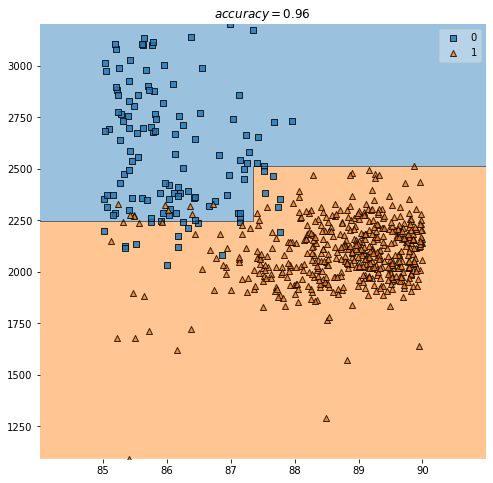

In [8]:
clf=DecisionTreeClassifier(max_depth=3, random_state=1337)
clf=clf.fit(X,y)

plt.figure(figsize=(8,8))
plot_decision_regions(X.to_numpy(), y, clf, ax=plt.gca())
plt.gca().set_title(f"$accuracy={clf.score(X,y):.2f}$");

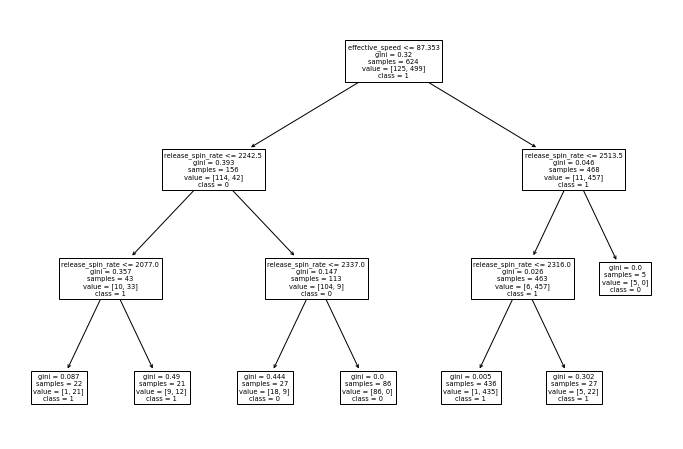

In [9]:
# Now this tree looks no different from the previous one. And our accuracy
# is the same. So what gives? Let's take a look at the plot.
from sklearn.tree import plot_tree
fig= plt.figure(figsize=(12,8))
plot_tree(clf, feature_names=X.columns, class_names=np.unique(y.astype(str)));

Let's spend our time on that left hand side. We see that both nodes split on anopther value of release spin rate. But, it didn't change any of our classifications! Both subtrees are either 1 or 0, it doesn't seem that any new information has been gained. Well, this isn't completely true. There is more segmentation going on, but the decision boundary space is still the same. That is, we can't see the splits because we're still predicting the same class outcomes. This tree is no more useful for prediction than the last.

Now, if you go look at the sklearn documentation you'll see that there is a parameter to control pruning of the tree, or removing branching just like this, called *ccp_alpha*. By default there is no pruning being done, so CART just continues to split based on the purity of the split choice until you get to a gini of 0 -- a completely homogenous class. We can see this happened on the far right side of the tree. So what's going to happen if we decide to keep recursing down in this tree?

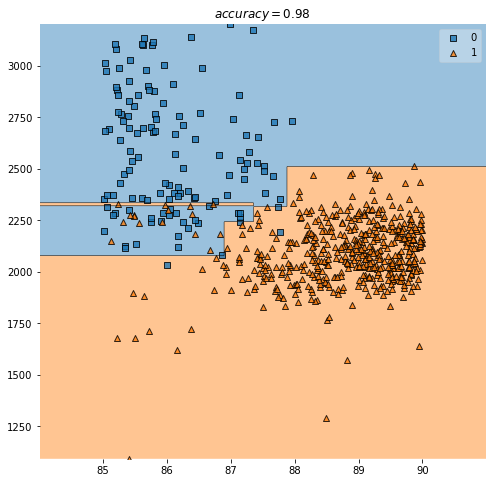

In [10]:
clf=DecisionTreeClassifier(max_depth=4, random_state=1337)
clf=clf.fit(X,y)

plt.figure(figsize=(8,8))
plot_decision_regions(X.to_numpy(), y, clf, ax=plt.gca())
plt.gca().set_title(f"$accuracy={clf.score(X,y):.2f}$");

Wow! Doesn't that look odd? You see, the previous level set up this level to split a bit more intelligently, and our accuracy has increased. We can see that there is a very small line of orange on the left hand side which captures maybe four triangles. We also have a bit more granularity on the diagnol line, which looks like a set of steps. This actually demonstrates something really important about descision trees versus, say, SVMs. Descision trees are sensitive to the rotation of our data points -- splits are always a single feature, either X or Y axis in this case, while a linear SVM, for instance, was a straight line in any direction. If you know your data is separated by a diagnol, then it is better to use an SVM or, transform your data by rotating it if you want to use a descision tree.